In [10]:
#import stuff
import pandas as p
import numpy as n
import seaborn as s
from matplotlib import pyplot as plt
import lib as l

In [60]:
#import data
pokemon = p.read_csv('data/pokemon.csv', header = None, 
                     skiprows=1, encoding = 'latin-1', low_memory = False,
                    names = ['Name', 'Version', 'Primary Type' ,'Secondary Type', 'Attack', 'Defense' , 'HP', 'Sp. Attack', 'Sp. Defense', 'Speed', 'Total']
)
noMega = pokemon[pokemon['Version'].isnull()] # for KNN alg

img = plt.imread("logo.png") # get the pokemon logo :)

# Question 1;

This is the data set of all current pokemon as of 11/23/21. This represents a statistical outlook of the 1045 pokemon. This includes legendaries, mythical, and mega evolution variants. Their attributes are broken down into 7 numerical categories. They represents how strong the corresponding attribute of the pokemon is. So the higher the value, the stronger the attribute will be. The categories are as follows:

    - HP
    - Attack
    - Defense
    - Special Attack
    - Special Defense
    - Speed
    - Total
    
These are not the actual values of the attributes. _i.e._ If I have a Lvl 100 Venusaur, I won't have 82 Attack. It is more like a scale that determines the boundaries that a pokemon's attributes are tied to. 

# Question 2;

There are few, not so obvious **classes** that are present in this data set. One of which can be determining if a pokemon is considered _Statistically Strong_. This has a vague definition, but generally the higher the pokemon's attributes are, the better they can do in battle. For our purpose, we will define statistically strong as _having a higher total than 500, as well as having at least 3 of their 6 attributes being in the third quartile of all values._ This will hopefully eliminate any outliers or pokemon that have all their power in a few stats. **(Blissey)**

Another class is whether the pokemon have a secondary type or not. There really is no correlation with the data we currently have, but if we added a column that gave us the evolution stage that a pokemon is in, (1, 2, or 3), we could define secondary types with evolution stage as a potential class. 

## Important Statistics & Info of the Set:

We will be excluding ALL mega evolution forms of pokemon as well as **Eternamax** for our KNN alg because they will cause some annoying skewing.

We will provide some basic stats about our set below:

In [34]:
stats = noMega.describe()
stats

,Attack,Defense,HP,Sp. Attack,Sp. Defense,Speed,Total
count,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000
mean,76.017241,71.511494,68.705747,69.117241,69.387356,65.142529,419.881609
std,29.471188,29.532790,26.272334,29.061263,26.858630,28.109893,110.641038
min,5.000000,5.000000,1.000000,10.000000,20.000000,5.000000,180.000000
25%,55.000000,50.000000,50.000000,45.000000,50.000000,45.000000,320.000000
50%,75.000000,67.000000,65.000000,65.000000,65.000000,64.000000,430.000000
75%,95.000000,90.000000,80.000000,90.000000,85.000000,85.000000,500.000000
max,181.000000,230.000000,255.000000,173.000000,230.000000,200.000000,720.000000


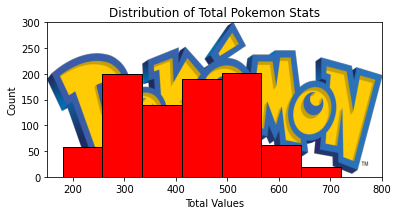

In [78]:
#distribution of total values
noMega['Total'].hist(color = 'red', ec = 'black', grid = False, bins = 7)
plt.title("Distribution of Total Pokemon Stats")
plt.xlabel("Total Values")
plt.ylabel("Count")
plt.imshow(img, extent = [150, 800, 0, 300])

# K-nearest Neighbors Algorithm

# K-means Clustering